<a href="https://colab.research.google.com/github/whtan88/RandomDataAnalyst_Projects/blob/main/Simple_Stock_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

To train a model to make a 1 time period step ahead closing stock price prediction. For the time period step ahead, we will be using a 1 week time interval.

In [26]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Download Dataset

Now, we will specify the current date, and download data from yahoo finance libary. For this case, we will specify the Netflix ticker NFLX to download, with a period starting from the year 2023. We will load at an interval of 1 week.

In [27]:
# Download Dataset
current_date = datetime.now().date()

ticker = 'NFLX'
df = yf.download(ticker, start='2023-01-01', end=current_date, interval='1wk', auto_adjust=True)
df = df.reset_index()
print(df.head())
print(df.info())

[*********************100%***********************]  1 of 1 completed

Price        Date       Close        High         Low        Open    Volume
Ticker                   NFLX        NFLX        NFLX        NFLX      NFLX
0      2023-01-01  315.549988  316.769989  288.700012  298.059998  33397300
1      2023-01-08  332.820007  336.649994  311.070007  316.829987  48561600
2      2023-01-15  342.500000  344.000000  313.390015  331.079987  63499600
3      2023-01-22  360.769989  369.019989  340.630005  341.720001  50170600
4      2023-01-29  365.899994  379.429993  348.709991  358.440002  36052500
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        130 non-null    datetime64[ns]
 1   (Close, NFLX)   130 non-null    float64       
 2   (High, NFLX)    130 non-null    float64       
 3   (Low, NFLX)     130 non-null    float64       
 4   (Open, NFLX)    130 non-null    float64       


We will do the following steps to preprocess the data. We will not be including any new features for now to inspect the feature importance.

*   Create a 1 time step ahead target closing price column as our dependent variable
*   Exclude last row from training data as target closing price is NaN.



In [28]:
# Prepare the target variable
df['target_close'] = df[('Close', ticker)].shift(-1)

# Excluding the last row as the target close is NaN
x_train = df.iloc[:-1].copy().drop(columns=['target_close','Date'])
y_train = df['target_close'][:-1]

df.tail()

/tmp/ipython-input-28-2074150497.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x_train = df.iloc[:-1].copy().drop(columns=['target_close','Date'])


Price,Date,Close,High,Low,Open,Volume,target_close
Ticker,,NFLX,NFLX,NFLX,NFLX,NFLX,
125,2025-05-25,1207.229980,1215.910034,1176.280029,1195.329956,12776300,1241.469971
126,2025-06-01,1241.469971,1262.810059,1196.250000,1201.199951,12391600,1212.150024
127,2025-06-08,1212.150024,1238.880005,1180.609985,1238.880005,13534700,1231.410034
128,2025-06-15,1231.410034,1248.500000,1212.199951,1212.199951,11634100,1323.119995
129,2025-06-22,1323.119995,1331.349976,1215.010010,1238.030029,17997398,NaN


# Training model and inspecting feature importance

Once data is prepared, we can train and fit the model.

We can also plot the feature importance to see which are the contributing features to predicting the closing target price. Using this analysis, we can use the information to iterate and do additional feature engineering.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

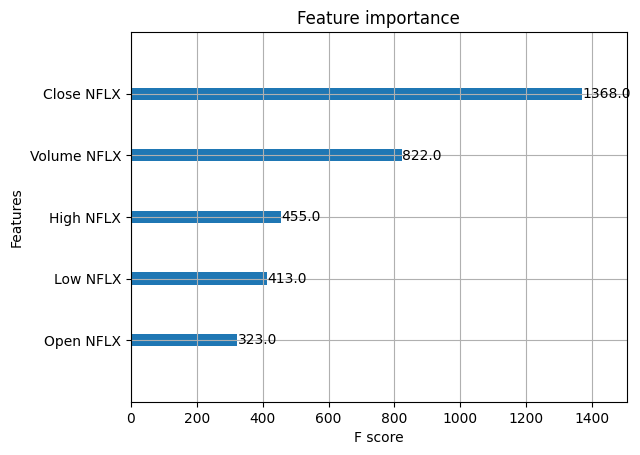

In [29]:
# Training an XGB model
reg = xgb.XGBRegressor(n_estimators=1000, random_state = 8)
reg.fit(x_train, y_train)

xgb.plot_importance(reg, max_num_features = 100)

# Feature Engineering

We will now create new features based on the feature importance plot above. From the graph, we can see that the close price has significant feature importance. As such, we can create several features based on the closing price.

As an example, we will create some ratios of closing price to the high, low and open prices. We will also include a simple moving average with 5 time periods. These will be the features we use in this example but you can iterate and choose more features to include to improve the stock price prediction.

In [30]:
# Simple Feature Engineering
df['ratio close to high'] = df[('Close', ticker)] / df[('High', ticker)]
df['ratio close to low'] = df[('Close', ticker)] / df[('Low', ticker)]
df['ratio open to high'] = df[('Open', ticker)] / df[('High', ticker)]
df['ratio open to low'] = df[('Open', ticker)] / df[('Low', ticker)]
df['ratio high to low'] = df[('High', ticker)] / df[('Low', ticker)]
df['SMA_5'] = df[('Close', ticker)].rolling(window=5).mean()

df.head()

Price,Date,Close,High,Low,Open,Volume,target_close,ratio close to high,ratio close to low,ratio open to high,ratio open to low,ratio high to low,SMA_5
Ticker,,NFLX,NFLX,NFLX,NFLX,NFLX,,,,,,,
0,2023-01-01,315.549988,316.769989,288.700012,298.059998,33397300,332.820007,0.996149,1.093003,0.940935,1.032421,1.097229,NaN
1,2023-01-08,332.820007,336.649994,311.070007,316.829987,48561600,342.500000,0.988623,1.069920,0.941126,1.018517,1.082232,NaN
2,2023-01-15,342.500000,344.000000,313.390015,331.079987,63499600,360.769989,0.995640,1.092887,0.962442,1.056447,1.097674,NaN
3,2023-01-22,360.769989,369.019989,340.630005,341.720001,50170600,365.899994,0.977643,1.059126,0.926020,1.003200,1.083346,NaN
4,2023-01-29,365.899994,379.429993,348.709991,358.440002,36052500,347.359985,0.964341,1.049296,0.944680,1.027903,1.088096,343.507996


After we have updated the data with new features, we will retrain the model using the data with new features.

From the training data below, you will notice that we dropped the first 4 rows. That is because with the inclusion of SMA, the first 4 values are NaN and will not be beneficial to training the model. As such, we will exclude them from the training dataset.

We can train and refit the model, and plot the feature importance graph again. We will probably have to repeat this several times and settle on an iteration where there is no single factor contributing to a significant feature importance.

/tmp/ipython-input-31-1200707686.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x_train = df.iloc[4:-1].copy().drop(columns=['target_close','Date'])


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

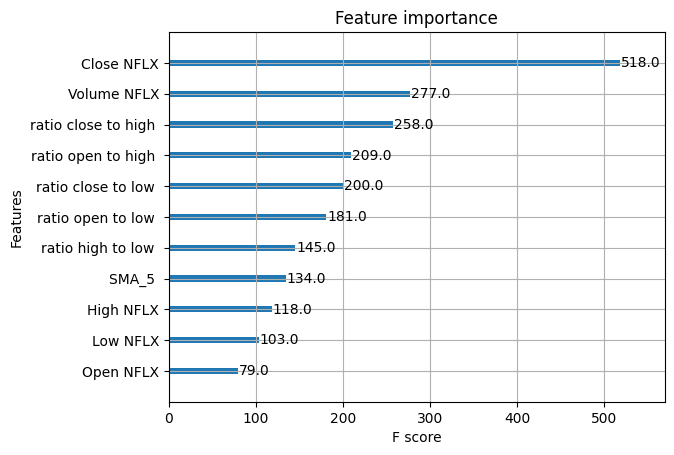

In [31]:
# Update training data with new features
x_train = df.iloc[4:-1].copy().drop(columns=['target_close','Date'])
y_train = df['target_close'][4:-1]

# Retraining the model with new features
reg.fit(x_train, y_train)

xgb.plot_importance(reg, max_num_features = 100)

# Making Prediction

Once we are satisfied with the model, we will use it to predict the 1 timestep ahead closing stock price using the last row. We can then print out the results to view it.

In [32]:
# Predicting 1 step ahead stock price
df_pred = df.iloc[-1:]
x_pred = df_pred.drop(columns=['target_close','Date'], axis=1)
y_pred = reg.predict(x_pred)

print(f'{ticker}')
print(f'Date close of prediction : {df["Date"].iloc[-1]}')
print(f'Predicted close : {y_pred[-1]:.2f}')

NFLX
Date close of prediction : 2025-06-22 00:00:00
Predicted close : 1308.13


/tmp/ipython-input-32-206914885.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x_pred = df_pred.drop(columns=['target_close','Date'], axis=1)


# Backtesting (Assessing model performance)

It is ideal to perform a backtest to assess the model performance. For this case, we will use a 1 month time period (4 data points) for our validation set. We will need to create a function, to retrain the model to include the incremental data as a feedback loop to increment the dataset and information that the model has to make better predictions.

We can also print metrics along with the predicted and actual closing stock price for comparison.

In [33]:
# Preparing backtest dataset
backtest_period = -5
y_test = df['target_close'][backtest_period:-1]

# Assessing and backtesting model performance
backtest_pred = []

for i in range(backtest_period,-1,1):
  df_backtest_train = df.iloc[:i]
  x_backtest_train = df_backtest_train.drop(columns=['target_close','Date'], axis=1)
  y_backtest_train = df_backtest_train['target_close']
  x_backtest_test = df.iloc[i:i+1].drop(columns=['target_close','Date'], axis=1)
  reg.fit(x_backtest_train, y_backtest_train)
  y_pred = reg.predict(x_backtest_test)
  backtest_pred.append(y_pred)

print(f'Backtest Results for {ticker}')
print(f'MSE: {mean_squared_error(y_test, backtest_pred):.2f}')
print(f'MAE: {mean_absolute_error(y_test, backtest_pred):.2f}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, backtest_pred):.2f}')

data = {'Actual': y_test, 'Predicted': backtest_pred}
df_backtest = pd.DataFrame(data)
print(df_backtest)

/tmp/ipython-input-33-1680997697.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x_backtest_train = df_backtest_train.drop(columns=['target_close','Date'], axis=1)
/tmp/ipython-input-33-1680997697.py:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x_backtest_test = df.iloc[i:i+1].drop(columns=['target_close','Date'], axis=1)
/tmp/ipython-input-33-1680997697.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x_backtest_train = df_backtest_train.drop(columns=['target_close','Date'], axis=1)
/tmp/ipython-input-33-1680997697.py:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x_backtest_test = df.iloc[i:i+1].drop(columns=['target_close','Date'], axis=1)
/tmp/ipython-input-33-1680997697.py:10: PerformanceWarning: dropping

Backtest Results for NFLX
MSE: 5086.50
MAE: 58.98
MAPE: 0.05
          Actual    Predicted
125  1241.469971    [1156.12]
126  1212.150024  [1206.5907]
127  1231.410034  [1194.4061]
128  1323.119995   [1215.133]


# Conclusion
We have just completed a simple walkthrough of using an XGB model to do stock price prediction. 2 important things to note would be feature engineering and backtesting to assess the model performance. It is important to experiment and try out different features, and use the backtest to assess the model performance and have certain thresholds for the metrics to ensure that the model is able to meet your expectation.